## Notes

Have a number of epochs (num-epochs) and at the start of each epoch you reset the training state

Each epoch has a number (epoch-size) of batches and at the end of each batch you update the weights

The batch is what you pass into sess.run

The batch is X, Y where X has dim [batch-size, num-steps, num-features] and Y has dim [batch-size, num-steps]

In [1]:
import new_rnn_functions
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import shutil
import os
from tensorflow.contrib import predictor


2019-01-28 21:59:34,020 matplotlib.backends DEBUG    backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
train_df, test_df = new_rnn_functions.load_data()

2019-01-28 21:59:40,314 root         DEBUG    loading entire df for river dart from sql
2019-01-28 21:59:42,244 root         DEBUG    Fill in missing timestamps by reindexing
2019-01-28 21:59:43,297 root         DEBUG    Convert cumulative rain to actual rain
2019-01-28 21:59:43,563 root         INFO     latest rain update at: 2018-08-19 21:00:00
2019-01-28 21:59:43,567 root         DEBUG    Concat rain and forecast to create model_rain
2019-01-28 21:59:43,603 root         DEBUG    interpolate model_rain


In [3]:
parameters = {
    "num_steps": 80,
    "batch_size": 150,
    "state_size": 15,
    "learning_rate": 0.1,
    "num_epochs": 10,
    "num_features": 3,
    "epoch_size": 200,
    "num_layers": 5,
    "num_level_updates": 40,
}

graph = new_rnn_functions.generate_graph(parameters)

In [4]:
# Test out the sample random generation

#X, Y = new_rnn_functions.create_random_samples(train_df, parameters, rain_threshold=20)
#new_rnn_functions.plot_sample(X, Y, index=120)

EPOCH 0
('Average loss at step', 50, 'for last 50 steps:', 0.10916009366512298)
('Average loss at step', 100, 'for last 50 steps:', 0.06046500816941261)
('Average loss at step', 150, 'for last 50 steps:', 0.046876438111066815)
EPOCH 1
('Average loss at step', 50, 'for last 50 steps:', 0.030570053942501545)
('Average loss at step', 100, 'for last 50 steps:', 0.025830222330987453)
('Average loss at step', 150, 'for last 50 steps:', 0.022860449627041816)
EPOCH 2
('Average loss at step', 50, 'for last 50 steps:', 0.021131493132561446)
('Average loss at step', 100, 'for last 50 steps:', 0.01919715477153659)
('Average loss at step', 150, 'for last 50 steps:', 0.01856784017756581)
EPOCH 3
('Average loss at step', 50, 'for last 50 steps:', 0.016352030988782643)
('Average loss at step', 100, 'for last 50 steps:', 0.01572064395993948)
('Average loss at step', 150, 'for last 50 steps:', 0.015140606332570314)
EPOCH 4
('Average loss at step', 50, 'for last 50 steps:', 0.015932467244565488)
('Averag

2019-01-28 21:06:16,810 tensorflow   INFO     Assets added to graph.


INFO:tensorflow:No assets to write.


2019-01-28 21:06:16,814 tensorflow   INFO     No assets to write.


INFO:tensorflow:SavedModel written to: /Users/jconn/isthedartrunning/analysis/models/test/saved_model.pb


2019-01-28 21:06:18,510 tensorflow   INFO     SavedModel written to: /Users/jconn/isthedartrunning/analysis/models/test/saved_model.pb


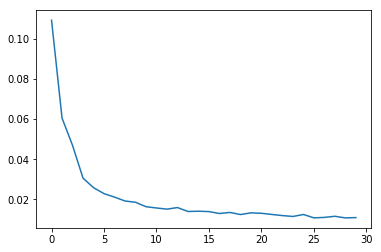

In [22]:
def run_training(train_df, parameters, graph, model_name):
    num_epochs = parameters["num_epochs"]
    batch_size = parameters["batch_size"]
    state_size = parameters["state_size"]
    num_epochs = parameters["num_epochs"]
    epoch_size = parameters["epoch_size"]
    
    train_step = graph["train_step"]
    total_loss = graph["total_loss"]
    final_state = graph["final_state"]
    losses = graph["losses"]
    predictions = graph["predictions"]
    x = graph["x"]
    y = graph["y"]
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        training_losses = []
        Ys = []
        preds = []
        for idx in range(num_epochs):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            print "EPOCH", idx
            for step in range(epoch_size):
                X, Y = new_rnn_functions.create_random_samples(train_df, parameters, rain_threshold=20)
                #print X.shape, Y.shape
                tr_losses, training_loss_, training_state, _, pred = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step,
                              predictions],
                                  feed_dict={x:X, y:Y})
                training_loss += training_loss_
                
                if step % 50 == 0 and step > 0:
                    print("Average loss at step", step,
                          "for last 50 steps:", training_loss/50)
                    training_losses.append(training_loss/50)
                    training_loss = 0
                
                    
        cwd = os.getcwd()
        path = os.path.join(cwd, 'models', model_name)
        shutil.rmtree(path, ignore_errors=True)
                    
        tf.saved_model.simple_save(
            sess,
            path,
            inputs={"x": x, "y": y},
            outputs={"predictions": predictions}
        )

    return training_losses, X, Y, pred

training_losses, final_X, final_Y, final_pred = run_training(train_df, parameters, graph, model_name="test")

plt.plot(training_losses)
plt.show()

# plot from the final predictions

new_rnn_functions.plot_sample(final_X, final_Y, final_pred, parameters=parameters, index=54)

In [5]:
import modelLib
def bucket_predict(inputs, num_level_updates):
    X = inputs["x"]
    pred = []
    for i in range(X.shape[0]):
        x = X[i,:,:]
        p = x[:, 2]
        starting_level = x[num_level_updates-1,2]
        storage=modelLib.f_inv(modelLib.g_inv(starting_level))
    
        for j in range(x.shape[0]-num_level_updates):
            rain = x[j+num_level_updates,0]
            predict = modelLib.g(modelLib.f(storage))
            storage = storage + rain - modelLib.f(storage)
            p[j+num_level_updates] = predict
        pred.append(p)
    return np.array(pred)

INFO:tensorflow:Restoring parameters from /Users/jconn/isthedartrunning/analysis/models/new_code_20_epoch_30_state_size/variables/variables


2019-01-28 21:59:54,866 tensorflow   INFO     Restoring parameters from /Users/jconn/isthedartrunning/analysis/models/new_code_20_epoch_30_state_size/variables/variables


TRAIN DATA
	Mean absolute error: 0.0619
	Root mean squared error: 0.095
	Mean absolute bucket_error: 0.0843
	Root mean squared bucket_error: 0.251

TEST DATA
	Mean absolute error: 0.0673
	Root mean squared error: 0.111
	Mean absolute bucket_error: 0.0887
	Root mean squared bucket_error: 0.276


2019-01-28 21:59:56,286 matplotlib.font_manager DEBUG    findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/Users/jconn/.julia/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


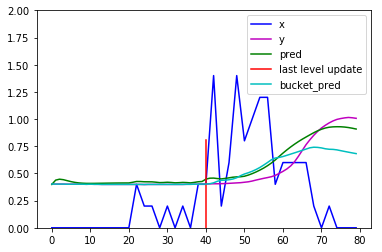

In [6]:
def evaluate_model(model_name, parameters, rain_threshold, index=1):
    cwd = os.getcwd()
    predict_fn = predictor.from_saved_model(os.path.join(cwd, "models", model_name))
    
    print "TRAIN DATA"
    X, Y = new_rnn_functions.create_random_samples(train_df, parameters, rain_threshold=rain_threshold)
    
    pred = predict_fn({"x":X})
    errors = np.abs(np.array(Y) - np.array(pred["predictions"]))
    print "\tMean absolute error:", errors.mean().round(4)
    print "\tRoot mean squared error:", round(math.sqrt((errors ** 2).mean()), 3)
    
    bucket_pred = bucket_predict({"x":X}, num_level_updates=parameters["num_level_updates"])
    bucket_errors = np.abs(np.array(Y) - np.array(bucket_pred))
    print "\tMean absolute bucket_error:", bucket_errors.mean().round(4)
    print "\tRoot mean squared bucket_error:", round(math.sqrt((bucket_errors ** 2).mean()), 3)
    
    print
    
    print "TEST DATA"
    X, Y = new_rnn_functions.create_random_samples(test_df, parameters, rain_threshold=rain_threshold)
    
    pred = predict_fn({"x":X})
    errors = np.abs(np.array(Y) - np.array(pred["predictions"]))
    print "\tMean absolute error:", errors.mean().round(4)
    print "\tRoot mean squared error:", round(math.sqrt((errors ** 2).mean()), 3)
    
    bucket_pred = bucket_predict({"x":X}, num_level_updates=parameters["num_level_updates"])
    bucket_errors = np.abs(np.array(Y) - np.array(bucket_pred))
    print "\tMean absolute bucket_error:", bucket_errors.mean().round(4)
    print "\tRoot mean squared bucket_error:", round(math.sqrt((bucket_errors ** 2).mean()), 3)

    new_rnn_functions.plot_sample(X, Y, pred["predictions"], parameters=parameters, bucket_pred=bucket_pred, index=index)
    
    
evaluate_model(model_name = "new_code_20_epoch_30_state_size", parameters=parameters, rain_threshold=20, index=24)

In [ ]:
/